In [1]:
import numpy as np
np.set_printoptions(linewidth=100)
import sympy as sm
import sympy.abc as sbl
from scipy.sparse import diags
import scipy.sparse.linalg as la
import scipy.sparse as sp
sm.init_printing()
import time
import matplotlib.pyplot as plt
import matplotlib

## Links to important Research Papers


<h3 align="center" style="color:#FFE647;">Equation   </h3> 
\begin{equation}
\\  A \alpha^{'} +\hspace{15mm}\beta ( D \alpha \hspace{10mm} - \hspace{10mm}E \alpha) \hspace{10mm} - \beta F  \alpha \hspace{15mm} = \hspace{15mm}f(t)
\end{equation}


\begin{equation}
\\  \alpha^{'} = -A^{-1}(\beta ( D \alpha  - E \alpha) - \beta F  \alpha - f(t)) \hspace{10mm} (i)
\\  \alpha^{'} = -A^{-1}( \beta ( D \alpha  - E \alpha -  F  \alpha )- f(t)) \hspace{10mm} (i)
\end{equation}



In [41]:
class Matrices:
    
    
    def __init__(self, N=10):
        
        
        self.N = N
        self.shape = (N+1, N+1)
        self.h = 1/N
        self.domain = np.linspace(0, 1, N+1) 
        self.beta = -1
        self.time_step = self.h**2
        self.runs = 1
        
        self.A = sp.csc_matrix(diags([       [self.h/6]*(N),   \
                                [self.h/3, *[2*self.h/3]*(N-1), self.h/3], \
                                     [self.h/6]*(N)],               [1, 0, -1] ), dtype=np.float32)

        self.B = np.array([self.matB(i) for i in range(N+1)]).reshape(N+1, 1) 

        self.C = sp.csr_matrix(diags([[1/2]*(N), [-1/2]+[0]*(N-1)+[1/2], [-1/2]*(N)] , [1, 0, -1]), dtype=np.float32)

        self.D = sp.csr_matrix(([-1/self.h, 1/self.h],([N, N-1], [N]*2)),shape=(N+1, N + 1))

        self.E = sp.csr_matrix( ([-1/self.h, 1/self.h],([0, 0], [0, 1])), shape=(N+1, N + 1))

        self.F = sp.csr_matrix(diags([      [-1/self.h]*(N),  
                                     [1/self.h, *[2/self.h]*(N-1), 1/self.h], \
                                          [-1/self.h]*(N)   ],       [1, 0, -1] ), dtype=np.float32)


        
        #Set initial conditions here
        self.alpha = np.sin(np.pi* self.domain).reshape(N+1, 1)
        
        #Set solution here
        self.exact = lambda t: np.exp(t)*np.sin(np.pi * self.domain)
        

    

    
    def matB(self,i):
            if i == 0 :
                row = np.array([0, 0, 1, 1])
                col = np.array([0, 1, 0, 1])
                data = np.array([-1/3, 1/3, -1/6, 1/6])
                return sp.csr_matrix((data, (row, col)), shape=self.shape,dtype=np.float32)        
            elif i == self.N:
                row = np.array([self.N-1, self.N - 1, self.N, self.N])
                col = np.array([self.N-1, self.N , self.N -1, self.N])
                data = np.array([-1/6, 1/6, -1/3, 1/3])
                return sp.csr_matrix((data, (row, col)), shape=self.shape, dtype=np.float32)   
            else:
                row = np.array([i-1]*3 + [i]*3 + [i+1]*3)
                col = np.array([col for col in range(i-1, i+1 + 1)]*3, dtype=np.float32)
                data = np.array([-1/6, 1/6, 0, -1/3, 0, 1/3, 0, -1/6, 1/6 ])
                return sp.csr_matrix((data, (row, col)), shape=self.shape, dtype=np.float32)    
            
   
    

In [42]:
class backward_euler(Matrices):
    
    def __init__(self, num_basis = 10):#, method = "backward_euler"):
     
        super().__init__(num_basis)
        
       
        x, k, t = sm.symbols("x k t")
        expr = sm.exp(t)*sm.sin(sm.pi*x)*(1+sm.pi**2)

        pos = sm.simplify(sm.integrate(expr*(x-(k-1)*self.h)/self.h, (x, self.h*(k-1),self.h*k)))
        neg = sm.simplify(sm.integrate(expr*-(x-(k+1)*self.h)/self.h, (x, self.h*(k),self.h*(k+1))))

        self.pos = sm.lambdify([k,t], pos, "numpy")
        self.neg = sm.lambdify([k,t], neg, "numpy")    

        #Backward Euler

        self.time_point = 0
        
        for i in range(self.runs):
            self.time_point += self.time_step  
            self.alpha[0], self.alpha[-1] = (0, 0)
            
            f_t =  (np.array([0]+[self.pos(k, self.time_point) for k in range(1, self.N+1)]) +\
                         np.array([self.neg(k, self.time_point) for k in range(0, self.N)]+[0])).reshape(self.N+1, 1)   
            
            self.alpha = la.inv(self.A-self.time_step * self.beta *(self.D - self.E - self.F)).dot\
                                (self.A.dot(self.alpha) + self.time_step * f_t)  
            
            
        self.approx = self.alpha.ravel()  

    def graph(self):
        plt.legend(["Approx", "Exact"])   


        return plt.plot(self.domain, self.approx, self.domain, self.exact(self.time_point))

In [43]:
#trash
class rk4(Matrices): 
    
    def __init__(self, num_basis = 10):#, method = "backward_euler"):

        super().__init__(num_basis)


        x, k, t = sm.symbols("x k t")
        expr = sm.exp(t)*sm.sin(sm.pi*x)*(1+sm.pi**2)

        pos = sm.simplify(sm.integrate(expr*(x-(k-1)*self.h)/self.h, (x, self.h*(k-1),self.h*k)))
        neg = sm.simplify(sm.integrate(expr*-(x-(k+1)*self.h)/self.h, (x, self.h*(k),self.h*(k+1))))

        self.pos = sm.lambdify([k,t], pos, "numpy")
        self.neg = sm.lambdify([k,t], neg, "numpy")

       #Runga Kutta 4th order 
        pos = self.pos  
        neg = self.neg
        self.time_point = 0
        
        def k(a):
            f_t = (  np.array([0]+[pos(k, self.time_point) for k in range(1, self.N+1)]) +\
                      np.array([neg(k, self.time_point) for k in range(0, self.N)]+[0]) \
                  ).reshape(self.N+1, 1)
            return -la.inv(self.A).dot(self.beta*((self.D - self.E - self.F).dot(a) - f_t))
            

        for i in range(self.runs):

            self.alpha[0] = 0
            self.alpha[-1] = 0
            
            k1 = k( self.alpha)
            k2 = k( self.alpha + .5*k1)
            print(k2)
            k3 = k( self.alpha + .5*k2)
            k4 = k( self.alpha + k3)
            self.alpha += (1/6)*(k1 + 2*k2 + 2*k3 + k4) * self.time_step
            self.time_point +=  self.time_step
           
        self.approx = self.alpha.ravel()  

    def graph(self):
        plt.legend(["Approx", "Exact"])   
        return plt.plot(self.domain, self.approx, self.domain, self.exact(self.time_point))

In [48]:
heat = backward_euler()


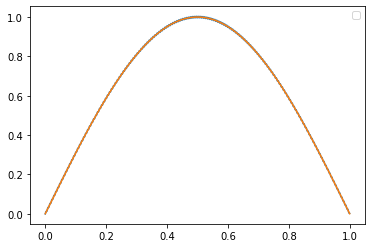

In [49]:
heat.graph()